In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt
import statsmodels.formula.api as sm

In [4]:
train = pd.read_csv("data/2022_FH.csv")
train = train.dropna(subset = ["Game Prep"])
train

/var/folders/j_/vxxst5h10rs21qx29q6pl7bh0000gn/T/ipykernel_30414/1944393370.py:1: DtypeWarning: Columns (59,63,67) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("data/2022_FH.csv")


,Week,Day,W L,Game Prep,Position,Athlete,Session Name,Session,Phase Name,Duration,...,TSB HSD,Decel Sum,Acute Decel,Chronic Decel,TSB Decel,HR 4 Percent,HR 5 Percent,Percent Above 80,TRIMP,Duration (min)
0,1,Wednesday,W,UConn,B,Maddie Bacskai,GD-2,Training,Whole session,3:35:43,...,1.00,25.0,12.25,12.25,1.0,11.43%,2.59%,14.02%,1222.39,216
1,1,Wednesday,W,UConn,F,Bente Baekers,GD-2,Training,Whole session,3:35:43,...,1.00,52.0,25.25,25.25,1.0,10.25%,0.80%,11.06%,1123.52,216
2,1,Wednesday,W,UConn,M,Jordan Carr,GD-2,Training,Whole session,3:35:43,...,1.00,74.0,36.50,36.50,1.0,18.93%,1.18%,20.11%,1240.37,216
3,1,Wednesday,W,UConn,M,Regan Cornelius,GD-2,Training,Whole session,3:35:43,...,1.00,71.0,34.50,34.50,1.0,9.56%,0.20%,9.76%,1132.51,216
4,1,Wednesday,W,UConn,B,Shannon Daley,GD-2,Training,Whole session,3:35:43,...,1.00,87.0,42.75,42.75,1.0,8.42%,0.56%,8.99%,1150.49,216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22398,65,Sunday,L,NCAA_UNC,M,Chloe Relford,NCAA_UNC,Game,4th quarter,0:21:54,...,1.17,19.0,36.18,32.85,1.1,23.59%,16.36%,39.95%,132.31,22
22399,65,Sunday,L,NCAA_UNC,GK,Annabel Skubisz,NCAA_UNC,Game,4th quarter,0:21:54,...,1.68,1.0,4.28,6.16,0.69,8.83%,0.00%,8.83%,128.66,22
22400,65,Sunday,L,NCAA_UNC,M,Lila Slattery,NCAA_UNC,Game,4th quarter,0:21:54,...,0.87,1.0,19.60,19.29,1.02,0.61%,0.00%,0.61%,103.11,22
22401,65,Sunday,L,NCAA_UNC,M,Lauren Wadas,NCAA_UNC,Game,4th quarter,0:21:54,...,0.88,22.0,27.36,27.92,0.98,24.81%,13.24%,38.05%,135.05,22


**Cleaning data**
- delete all rows that aren't preparing for a game
- only use fall data (August - Dec) - regular season data
- don't include HR% because practices are varying length - actual time is more important
- filter to only include "whole session"
- filter to players who played more than 800 minutes for the 2022 season
- filter out goalies

In [5]:
train["Date"] = pd.to_datetime(train['Date'])

In [6]:
#only keeping whole session, dates during season, and field player data
train = train[(train["Phase Name"] == "Whole session") & (train["Date"] >= "2022-08-01") & (train["Date"] <= "2022-12-01") & (train["Position"] != "GK")]

In [8]:
#filtering out data for only players with minutes above 800 minutes of playing time over the course of the season (total possible playing time around 1600 minutes)
high_min_players = ['Bente Baekers', 'Shannon Daley', 'Peyton Halsey', 'Ana Medina Garcia', 'Chloe Relford', 'Lauren Wadas','Madeleine Zimmer','Kayla Blas','Alia Marshall']
train = train.loc[train.Athlete.isin(high_min_players),:]

In [10]:
# dropping all NA W_L values bc that game was a scrimmage
train = train.dropna()

In [11]:
#adding a binary column for W and L
train.columns = train.columns.str.replace(' ', '_')
train['W_L_binary'] = train['W_L'].apply(lambda x: 0 if x=='L' else 1)
train.head()

,Week,Day,W_L,Game_Prep,Position,Athlete,Session_Name,Session,Phase_Name,Duration,...,Decel_Sum,Acute_Decel,Chronic_Decel,TSB_Decel,HR_4_Percent,HR_5_Percent,Percent_Above_80,TRIMP,Duration_(min),W_L_binary
13879,53,Thursday,W,Maine,F,Bente Baekers,GD-3,Training,Whole session,2:02:28,...,80.0,32.50,32.66,0.99,22.77%,7.09%,29.86%,699.08,122,1
13880,53,Thursday,W,Maine,B,Kayla Blas,GD-3,Training,Whole session,2:02:28,...,62.0,25.67,29.48,0.87,18.02%,0.00%,18.02%,653.16,122,1
13883,53,Thursday,W,Maine,B,Shannon Daley,GD-3,Training,Whole session,2:02:28,...,99.0,34.18,34.54,0.99,20.79%,6.76%,27.56%,683.77,122,1
13885,53,Thursday,W,Maine,M,Peyton Halsey,GD-3,Training,Whole session,2:02:28,...,65.0,29.62,28.14,1.05,14.02%,26.29%,40.31%,770.52,122,1
13892,53,Thursday,W,Maine,M,Alia Marshall,GD-3,Training,Whole session,2:02:28,...,57.0,25.48,26.50,0.96,16.59%,0.14%,16.73%,648.05,122,1


In [17]:
#Correlation data of train with W L
train.corrwith(train.W_L_binary).sort_values(ascending = False)

W_L_binary         1.000000
Chronic_TD         0.089316
TLScore_Chronic    0.080723
HR_AVG             0.054697
HR_Avg_Per         0.054277
Recovery           0.050656
Decel_2            0.023906
Acute_HIA          0.021393
HR_Max_Per         0.020642
HR_Max             0.019570
Chronic_HIA        0.015943
Speed_5            0.014181
TLScore_Acute      0.012378
Accel_4            0.010027
TLScore            0.007662
HIA                0.006607
Accel_3            0.005298
Accel_2            0.003867
Sprints            0.003068
Accel_1           -0.000331
HSD               -0.000598
Cardio_Load       -0.001973
Max_Speed         -0.006403
Speed_4           -0.009407
Calories          -0.010086
Decel_3           -0.015878
Decel_Sum         -0.022557
TRIMP             -0.026036
Speed_3           -0.026278
HR_Min_Per        -0.027399
HR_Min            -0.027632
Avg_Speed         -0.029634
Decel_1           -0.029789
Acute_Decel       -0.033751
Distance/min      -0.036929
Chronic_Decel     -0

In [18]:
train_game_M = train[(train["Session"] == "Game")&(train["Position"] == "M")]
train_game_M.corrwith(train_game_M.W_L_binary).sort_values(ascending = False)

W_L_binary         1.000000
Recovery           0.162462
HR_Avg_Per         0.145143
HR_AVG             0.141506
TRIMP              0.133165
Accel_1            0.131045
Calories           0.126332
Cardio_Load        0.122943
HR_Min             0.117563
HR_Min_Per         0.115559
Decel_1            0.115140
TLScore_Acute      0.113712
TLScore            0.113245
TLScore_Chronic    0.107379
Chronic_TD         0.096225
Decel_2            0.092019
Duration_(min)     0.071177
Speed_5            0.067065
TSB_HR_Sum         0.062647
TLScore_TSB        0.046263
Acute_HIA          0.039061
HSD                0.035290
HIA                0.029915
Accel_3            0.029577
Accel_2            0.023324
Accel_4            0.021017
Speed_2            0.020103
Max_Speed          0.003275
Speed_4            0.002453
Chronic_HIA        0.000328
Total_Distance    -0.010148
Acute_TD          -0.011122
Sprints           -0.013303
Acute_Decel       -0.022659
Speed_1           -0.027020
HR_Max            -0

In [19]:
train_game_F = train[(train["Session"] == "Game")&(train["Position"] == "F")]
train_game_F.corrwith(train_game_F.W_L_binary).sort_values(ascending = False)

W_L_binary         1.000000
TLScore_Chronic    0.329516
Chronic_TD         0.326833
Chronic_Decel      0.279550
Speed_5            0.273704
Accel_1            0.252612
Max_Speed          0.225832
Decel_1            0.224672
Decel_3            0.202053
Chronic_HIA        0.199969
Recovery           0.195473
Accel_2            0.130604
Calories           0.129826
Cardio_Load        0.123289
TLScore            0.117309
TLScore_Acute      0.106532
Sprints            0.106063
Decel_2            0.086753
Duration_(min)     0.058072
Speed_2            0.048437
TRIMP              0.048218
Decel_Sum          0.046854
HSD                0.028243
Total_Distance     0.021230
Accel_4            0.015275
HR_Max             0.011950
HR_Max_Per         0.010667
Speed_3           -0.012085
HR_Avg_Per        -0.017849
Acute_Decel       -0.021114
HR_AVG            -0.022504
Speed_1           -0.025227
Distance/min      -0.040021
HIA               -0.107486
TLScore_TSB       -0.125727
HR_Min_Per        -0

In [20]:
train_game_B = train[(train["Session"] == "Game")&(train["Position"] == "B")]
train_game_B.corrwith(train_game_B.W_L_binary).sort_values(ascending = False)

W_L_binary         1.000000
Decel_1            0.146810
Max_Speed          0.143344
Accel_1            0.112939
TLScore_Chronic    0.069957
Recovery           0.065772
Chronic_TD         0.062991
Duration_(min)     0.058751
Calories           0.056564
TRIMP              0.055899
Speed_4            0.046299
HR_Max_Per         0.041698
HR_Max             0.034122
Accel_2            0.032669
Cardio_Load        0.027166
Chronic_HIA        0.026879
Decel_2            0.026694
TLScore            0.023433
Acute_HIA          0.017220
HR_AVG             0.006362
HSD                0.003693
Speed_1            0.001728
HR_Avg_Per        -0.002147
Speed_3           -0.003498
Total_Distance    -0.006274
Speed_2           -0.010365
Accel_3           -0.011553
HIA               -0.016058
Accel_4           -0.024446
Decel_4           -0.030917
Chronic_Decel     -0.033406
Speed_5           -0.040483
Sprints           -0.057252
TLScore_Acute     -0.064188
Acute_TD          -0.066487
Avg_Speed         -0

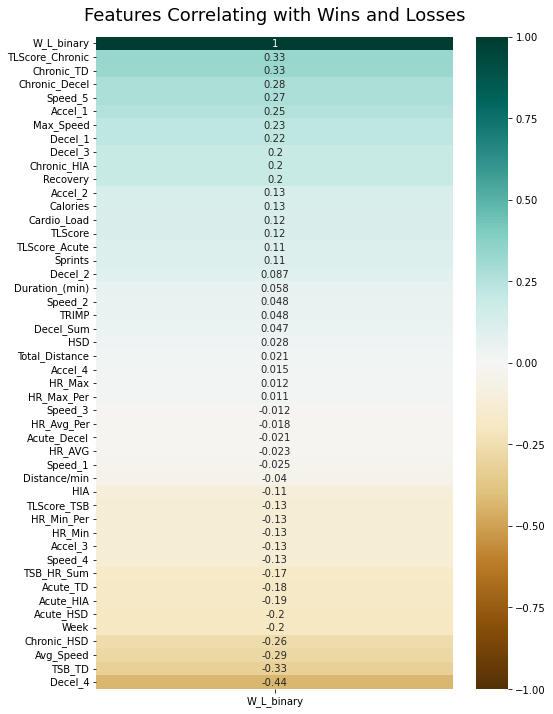

In [23]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train_game_F.corr()[['W_L_binary']].sort_values(by='W_L_binary', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Wins and Losses', fontdict={'fontsize':18}, pad=16);